In [1]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 31 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (160 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [37]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import tensorflow as tf
import time
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import faiss
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Defining 50 layer residual network : ResNet50 trained on million images, to get features for our dataset.
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))

#Extracting features of images by including image path and model trained above
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - 1s 0us/step


In [5]:
!unzip '/content/drive/MyDrive/ADM_Assignment/Assignment_3/Dataset.zip' -d '/content/images/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/images/Dataset/1000012591_395792_2.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000012591_395792_2.jpeg  
  inflating: /content/images/Dataset/1000015780_227224_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000015780_227224_1.jpeg  
  inflating: /content/images/Dataset/1000006354_226136_2.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000006354_226136_2.jpeg  
  inflating: /content/images/Dataset/1000005296_1257573_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000005296_1257573_1.jpeg  
  inflating: /content/images/Dataset/1000009561_1748445_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000009561_1748445_1.jpeg  
  inflating: /content/images/Dataset/1000011715_1200098_1.jpeg  
  inflating: /content/images/__MACOSX/Dataset/._1000011715_1200098_1.jpeg  
  inflating: /content/images/Dataset/1000019295_2837375_1.jpeg  
  inflating: /content/images/__MACOSX/Datase

In [6]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list
root_dir = '/content/drive/images'
filenames = sorted(get_file_list(root_dir))

In [10]:
import glob
img_lst = []
image_paths = glob.glob('/content/images/Dataset/*.jpeg')
for image_path in image_paths:
  img_lst.append(image_path)


In [14]:
#Sampling the dataset, as the program takes a lot of time to run
imglist = img_lst[:1000]

In [15]:
feature_list = []
for i in tqdm_notebook(range(len(imglist))):
    feature_list.append(extract_features(imglist[i], model))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [16]:
features=np.array(feature_list)
features.shape

(1000, 100352)

In [40]:
dimensions=features.shape[1]
db_vectors=features 
nlist = 1  # number of clusters
quantiser = faiss.IndexFlatL2(dimensions) #to assign the vectors to a particular cluster. This is index that uses the L2 distance metric 
index = faiss.IndexIVFFlat(quantiser, dimensions, nlist,   faiss.METRIC_L2) #defining index

In [41]:
print(index.is_trained)   # False
index.train(db_vectors)  # train on the database vectors
print(index.ntotal)   # 0
index.add(db_vectors)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal) 

False
0
True
1000


In [46]:
nprobe = 1  # find 2 most similar clusters
n_query = 1000  
k = 10  # return 3 nearest neighbours
np.random.seed(0)   
#Trying out a random images at 23rd position in images folder :
distances, indices = index.search(features, k)

In [47]:
distances

array([[0.        , 1.3488921 , 1.3634825 , ..., 1.4259896 , 1.4289706 ,
        1.4297419 ],
       [0.        , 0.02801833, 0.336205  , ..., 1.3295441 , 1.3355764 ,
        1.3560301 ],
       [0.        , 0.7775734 , 0.8731864 , ..., 1.1893901 , 1.209977  ,
        1.2120947 ],
       ...,
       [0.        , 1.1177884 , 1.1817039 , ..., 1.2595681 , 1.2596517 ,
        1.2891814 ],
       [0.        , 0.        , 0.9391116 , ..., 1.0041226 , 1.0415584 ,
        1.0435319 ],
       [0.        , 0.8789262 , 0.9389489 , ..., 1.3041183 , 1.3050811 ,
        1.3138143 ]], dtype=float32)

In [48]:
indices

array([[  0, 259, 721, ..., 673, 697, 376],
       [  1,  53,  95, ..., 956,  60, 640],
       [  2, 775, 682, ..., 370, 500, 819],
       ...,
       [997, 570, 752, ..., 993, 803, 319],
       [281, 998,   7, ..., 516, 658, 752],
       [999, 417, 793, ..., 149, 646, 389]])

In [32]:
def faiss_similarity(img):
  feature_list=extract_features('/content/images/Dataset/'+str(img), model)
  nprobe = 2  # find 2 most similar clusters
  n_query = 1  
  print(feature_list)
  k = 10  # return 10 nearest neighbours
  np.random.seed(0)
  dimensions=len(feature_list)   
  query_vectors = np.random.random((n_query, dimensions)).astype('float32')
  distances, indices = index.search(feature_list.reshape(1,-1), k)
  list_ind=indices.flatten().tolist()
  f, ax = plt.subplots(1, 10, figsize=(16, 8))
  for i,j in enumerate(list_ind):
    ax[i].imshow(plt.imread(imglist[j]))
    ax[i].set_axis_off()
  plt.show()

[0.         0.         0.00395092 ... 0.02210247 0.         0.        ]


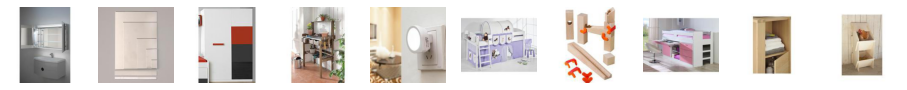

In [33]:
faiss_similarity('1000000461_1024049_4.jpeg')
#/content/images/Dataset/1000000461_1024049_4.jpeg

In [34]:
len(feature_list)

1000

In [35]:
len(imglist)

1000

In [58]:
imglist2 = []
for i in range(len(imglist)):
  imglist2.append(imglist[i].split('/')[4])
print(len(imglist2))

1000


In [59]:
df_img = pd.DataFrame()
df_img['img'] = imglist2
df_img

,img
0,1000019142_5917393_1.jpeg
1,1000014826_1543272_3.jpeg
2,1000019446_1415298_1.jpeg
3,1000015780_520991_1.jpeg
4,1000016486_250472_1.jpeg
...,...
995,1000020717_809874_4.jpeg
996,1000019289_437595_1.jpeg
997,1000006354_150726_1.jpeg
998,1000018015_597016_1.jpeg


In [60]:
df_indices = pd.DataFrame(indices)
imgref = df_img.to_dict()
imgref = imgref['img']
imgref

{0: '1000019142_5917393_1.jpeg',
 1: '1000014826_1543272_3.jpeg',
 2: '1000019446_1415298_1.jpeg',
 3: '1000015780_520991_1.jpeg',
 4: '1000016486_250472_1.jpeg',
 5: '1000018977_2544621_3.jpeg',
 6: '1000018483_271601_4.jpeg',
 7: '1000005613_1125137_1.jpeg',
 8: '1000017306_131494_0.jpeg',
 9: '1000016591_1328004_3.jpeg',
 10: '1000020031_4177251_2.jpeg',
 11: '1000012299_1459779_2.jpeg',
 12: '1000013443_1552575_1.jpeg',
 13: '1000012591_1096300_2.jpeg',
 14: '1000011715_1227403_2.jpeg',
 15: '1000002312_257410_1.jpeg',
 16: '1000002619_332676_2.jpeg',
 17: '1000017981_2090707_1.jpeg',
 18: '1000004228_362292_1.jpeg',
 19: '1000005296_1015879_1.jpeg',
 20: '1000019289_117487_1.jpeg',
 21: '1000017981_3417021_1.jpeg',
 22: '1000014148_255589_1.jpeg',
 23: '1000002553_67847_1.jpeg',
 24: '1000008761_227385_2.jpeg',
 25: '1000017573_1602333_1.jpeg',
 26: '1000002999_3100944_4.jpeg',
 27: '1000013499_6938441_1.jpeg',
 28: '1000003705_247744_3.jpeg',
 29: '1000016180_3744621_1.jpeg',
 30

In [61]:
df_indices = df_indices.replace(imgref)
df_indices

,0,1,2,3,4,5,6,7,8,9
0,1000019142_5917393_1.jpeg,1000004309_1309566_4.jpeg,1000019295_3337972_1.jpeg,1000012591_1040368_3.jpeg,1000019295_3420419_2.jpeg,1000001974_174599_3.jpeg,1000001589_268647_2.jpeg,1000002999_4372504_2.jpeg,1000002181_1997020_1.jpeg,1000009561_1418640_4.jpeg
1,1000014826_1543272_3.jpeg,1000014826_1543272_1.jpeg,1000014826_1543272_2.jpeg,1000010410_53288_1.jpeg,1000002312_737082_4.jpeg,1000018015_1264572_1.jpeg,1000019446_1537449_1.jpeg,1000018606_1752558_3.jpeg,1000014826_2214265_3.jpeg,1000004309_766190_1.jpeg
2,1000019446_1415298_1.jpeg,1000019446_824087_1.jpeg,1000019446_1537449_1.jpeg,1000004309_561313_1.jpeg,1000019295_3418326_1.jpeg,1000019446_1696752_3.jpeg,1000020743_2649803_1.jpeg,1000020743_5959036_1.jpeg,1000020743_1676168_1.jpeg,1000019446_83218_1.jpeg
3,1000015780_520991_1.jpeg,1000015780_563909_2.jpeg,1000015780_344067_1.jpeg,1000015780_437270_2.jpeg,1000015780_109986_1.jpeg,1000015780_263328_2.jpeg,1000015780_116968_1.jpeg,1000014545_1362713_1.jpeg,1000019470_558190_2.jpeg,1000018433_697632_1.jpeg
4,1000016486_250472_1.jpeg,1000016486_11905_1.jpeg,1000002827_208982_1.jpeg,1000002827_174494_1.jpeg,1000002827_397759_1.jpeg,1000002827_103681_1.jpeg,1000002827_210074_1.jpeg,1000016486_255254_1.jpeg,1000002827_398797_1.jpeg,1000002827_184168_1.jpeg
...,...,...,...,...,...,...,...,...,...,...
995,1000020717_809874_4.jpeg,1000018015_597016_1.jpeg,1000018015_2222616_1.jpeg,1000018015_2282093_1.jpeg,1000015900_244170_0.jpeg,1000001974_248843_1.jpeg,1000001974_221233_4.jpeg,1000007560_1319389_2.jpeg,1000002553_87164_2.jpeg,1000018657_707556_3.jpeg
996,1000019289_437595_1.jpeg,1000019289_168024_1.jpeg,1000006420_405000_1.jpeg,1000019289_417949_2.jpeg,1000006420_199698_1.jpeg,1000006420_393744_2.jpeg,1000006420_284047_1.jpeg,1000006420_425883_1.jpeg,1000019289_391355_1.jpeg,1000019289_175792_1.jpeg
997,1000006354_150726_1.jpeg,1000019645_92471_1.jpeg,1000005613_486098_1.jpeg,1000018433_2721053_3.jpeg,1000011715_999455_2.jpeg,1000005613_440733_1.jpeg,1000019142_3777390_1.jpeg,1000018433_213730_1.jpeg,1000005736_990346_1.jpeg,1000005613_481938_1.jpeg
998,1000018015_2222616_1.jpeg,1000018015_597016_1.jpeg,1000005613_1125137_1.jpeg,1000002553_87164_2.jpeg,1000020717_809874_4.jpeg,1000005613_750918_1.jpeg,1000005613_1118355_1.jpeg,1000005613_694580_1.jpeg,1000002553_87164_4.jpeg,1000005613_486098_1.jpeg


In [62]:
df_indices.to_csv('Faiss.csv')